### Imports

In [1]:
import os
import time
import math
import random
import pickle
import shutil
import warnings

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from models import *
from autoencoder import *
from utils import *
from data import *

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

### Configuration Setup

Defines experiment parameters, including latent dimension size, datasets (length and window size),  and distance metrics. The compute device (CPU/GPU) is selected automatically.

The experiment will be conducted using three distinct datasets:
- Energy Dataset: 
- River Flow Dataset:
- Temperatures Dataset:
- Births Dataset:

In [2]:
# Configuration Parameters
latent_dim = 8

# Dataset configurations: (Name, Class, Sequence Length, Window Size)
ts_configs = [
    ("Energy",       PowerDemand,  None, 10),
    ("RiverFlow",    Saugeen,      None, 10),
    ("Temperatures", Temperatures, None, 10),
    ("Births",       Births,       None, 10)
]

# Flags to toggle use of autoencoder embeddings
autoencoder_embedding_flags = [False, True]

# Distance metrics to evaluate
metrics_list = ["euclidean", "manhattan", "cosine"]

# Set device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Autoencoder Training and Evaluation

For each dataset, a convolutional autoencoder is trained on windowed time-series data using MSE loss. The model is trained for 30 epochs and saved for later use.


Training AE on Energy (window_size=10)
  Epoch 1/30 — loss: 0.395991
  Epoch 2/30 — loss: 0.135298
  Epoch 3/30 — loss: 0.105573
  Epoch 4/30 — loss: 0.088848
  Epoch 5/30 — loss: 0.079535
  Epoch 6/30 — loss: 0.071665
  Epoch 7/30 — loss: 0.066789
  Epoch 8/30 — loss: 0.064517
  Epoch 9/30 — loss: 0.061330
  Epoch 10/30 — loss: 0.059012
  Epoch 11/30 — loss: 0.058075
  Epoch 12/30 — loss: 0.056205
  Epoch 13/30 — loss: 0.054883
  Epoch 14/30 — loss: 0.053548
  Epoch 15/30 — loss: 0.053945
  Epoch 16/30 — loss: 0.053572
  Epoch 17/30 — loss: 0.051370
  Epoch 18/30 — loss: 0.049998
  Epoch 19/30 — loss: 0.049227
  Epoch 20/30 — loss: 0.048002
  Epoch 21/30 — loss: 0.048100
  Epoch 22/30 — loss: 0.046793
  Epoch 23/30 — loss: 0.046427
  Epoch 24/30 — loss: 0.045976
  Epoch 25/30 — loss: 0.045536
  Epoch 26/30 — loss: 0.045155
  Epoch 27/30 — loss: 0.045270
  Epoch 28/30 — loss: 0.044255
  Epoch 29/30 — loss: 0.044122
  Epoch 30/30 — loss: 0.043733
Saved AE: autoencoders\ae_Energy.pth


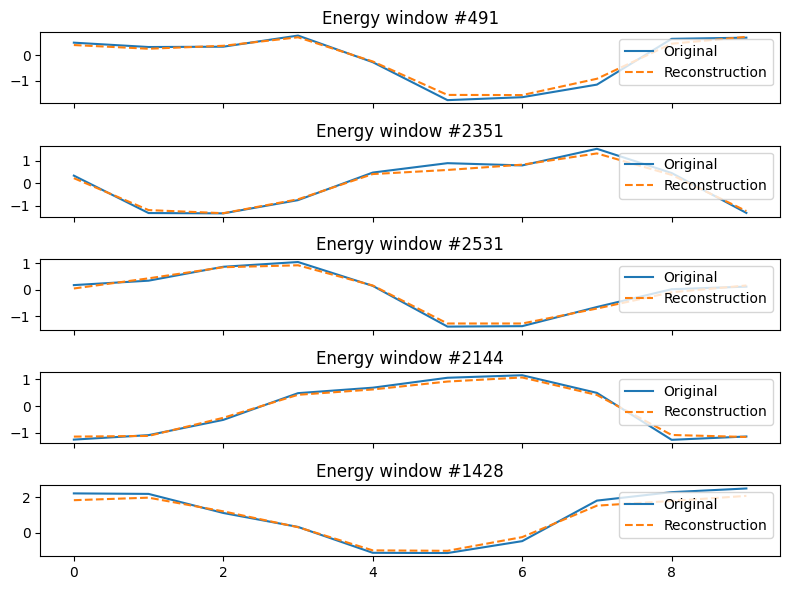


Training AE on RiverFlow (window_size=10)
  Epoch 1/30 — loss: 0.241821
  Epoch 2/30 — loss: 0.115310
  Epoch 3/30 — loss: 0.097388
  Epoch 4/30 — loss: 0.085536
  Epoch 5/30 — loss: 0.077247
  Epoch 6/30 — loss: 0.071895
  Epoch 7/30 — loss: 0.078029
  Epoch 8/30 — loss: 0.069837
  Epoch 9/30 — loss: 0.060255
  Epoch 10/30 — loss: 0.057374
  Epoch 11/30 — loss: 0.057898
  Epoch 12/30 — loss: 0.054273
  Epoch 13/30 — loss: 0.056014
  Epoch 14/30 — loss: 0.057790
  Epoch 15/30 — loss: 0.049268
  Epoch 16/30 — loss: 0.051800
  Epoch 17/30 — loss: 0.053258
  Epoch 18/30 — loss: 0.047955
  Epoch 19/30 — loss: 0.048319
  Epoch 20/30 — loss: 0.046078
  Epoch 21/30 — loss: 0.042336
  Epoch 22/30 — loss: 0.045094
  Epoch 23/30 — loss: 0.041604
  Epoch 24/30 — loss: 0.041496
  Epoch 25/30 — loss: 0.039874
  Epoch 26/30 — loss: 0.036111
  Epoch 27/30 — loss: 0.038595
  Epoch 28/30 — loss: 0.037052
  Epoch 29/30 — loss: 0.038906
  Epoch 30/30 — loss: 0.037555
Saved AE: autoencoders\ae_RiverFlow.

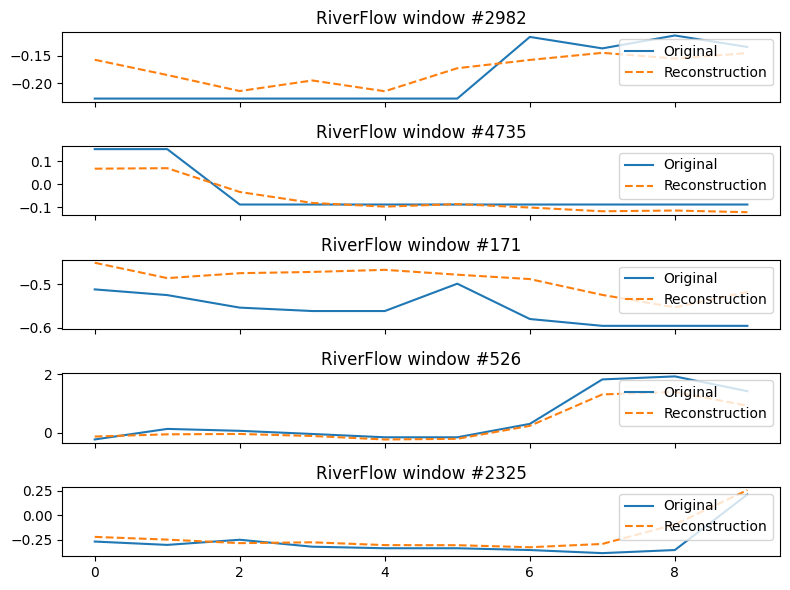


Training AE on Temperatures (window_size=10)
  Epoch 1/30 — loss: 0.607393
  Epoch 2/30 — loss: 0.288042
  Epoch 3/30 — loss: 0.233736
  Epoch 4/30 — loss: 0.205398
  Epoch 5/30 — loss: 0.177867
  Epoch 6/30 — loss: 0.160925
  Epoch 7/30 — loss: 0.156487
  Epoch 8/30 — loss: 0.140720
  Epoch 9/30 — loss: 0.135080
  Epoch 10/30 — loss: 0.127342
  Epoch 11/30 — loss: 0.121843
  Epoch 12/30 — loss: 0.118223
  Epoch 13/30 — loss: 0.114585
  Epoch 14/30 — loss: 0.111716
  Epoch 15/30 — loss: 0.111665
  Epoch 16/30 — loss: 0.107763
  Epoch 17/30 — loss: 0.103298
  Epoch 18/30 — loss: 0.097633
  Epoch 19/30 — loss: 0.099578
  Epoch 20/30 — loss: 0.093993
  Epoch 21/30 — loss: 0.089613
  Epoch 22/30 — loss: 0.085383
  Epoch 23/30 — loss: 0.088336
  Epoch 24/30 — loss: 0.086895
  Epoch 25/30 — loss: 0.080911
  Epoch 26/30 — loss: 0.078711
  Epoch 27/30 — loss: 0.083399
  Epoch 28/30 — loss: 0.078322
  Epoch 29/30 — loss: 0.087878
  Epoch 30/30 — loss: 0.077557
Saved AE: autoencoders\ae_Tempera

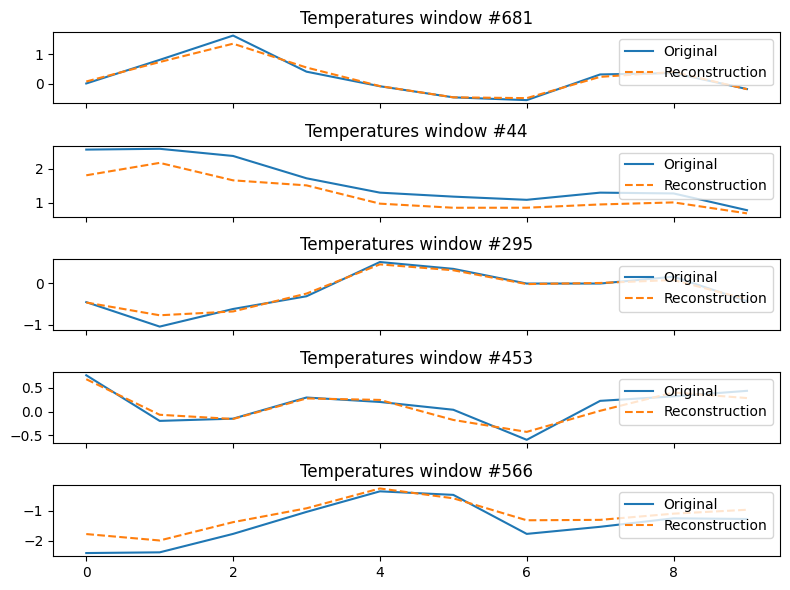


Training AE on Births (window_size=10)
  Epoch 1/30 — loss: 0.582606
  Epoch 2/30 — loss: 0.265211
  Epoch 3/30 — loss: 0.179650
  Epoch 4/30 — loss: 0.143155
  Epoch 5/30 — loss: 0.123757
  Epoch 6/30 — loss: 0.112682
  Epoch 7/30 — loss: 0.098731
  Epoch 8/30 — loss: 0.091611
  Epoch 9/30 — loss: 0.088488
  Epoch 10/30 — loss: 0.082490
  Epoch 11/30 — loss: 0.077796
  Epoch 12/30 — loss: 0.076627
  Epoch 13/30 — loss: 0.072937
  Epoch 14/30 — loss: 0.072302
  Epoch 15/30 — loss: 0.071385
  Epoch 16/30 — loss: 0.071915
  Epoch 17/30 — loss: 0.070980
  Epoch 18/30 — loss: 0.067509
  Epoch 19/30 — loss: 0.069125
  Epoch 20/30 — loss: 0.068585
  Epoch 21/30 — loss: 0.064836
  Epoch 22/30 — loss: 0.064466
  Epoch 23/30 — loss: 0.066423
  Epoch 24/30 — loss: 0.061839
  Epoch 25/30 — loss: 0.061552
  Epoch 26/30 — loss: 0.063966
  Epoch 27/30 — loss: 0.062375
  Epoch 28/30 — loss: 0.060843
  Epoch 29/30 — loss: 0.060898
  Epoch 30/30 — loss: 0.059665
Saved AE: autoencoders\ae_Births.pth


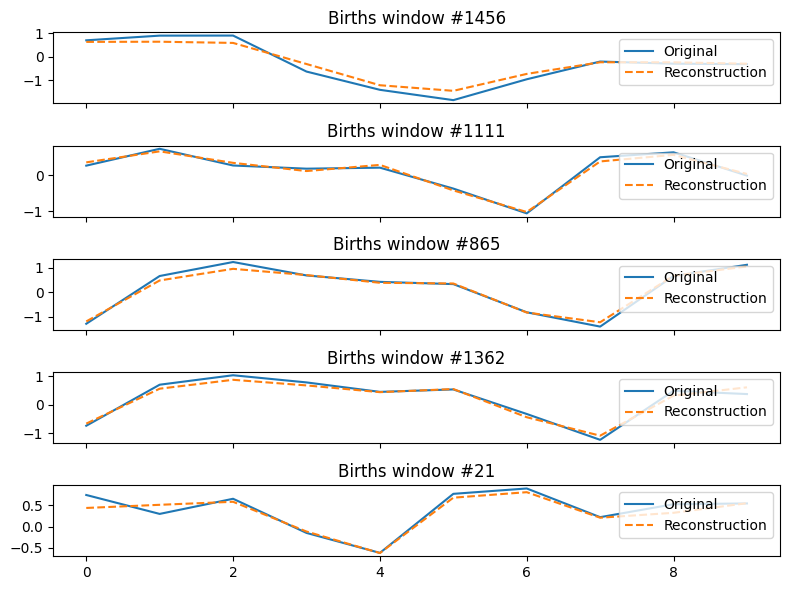

In [3]:
# Autoencoder Training Settings
epochs    = 30
lr        = 1e-3
dropout_p = 0.3

# Ensure a clean autoencoders/ directory
AE_DIR = "autoencoders"
if os.path.exists(AE_DIR):
    shutil.rmtree(AE_DIR)
os.makedirs(AE_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\nTraining AE on {ds_name} (window_size={window_size})")
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    
    
    # model + optimizer + loss
    ae        = ConvAutoencoder1D(window_size, latent_dim, dropout_p).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # wrap as DataLoader of shape (batch, 1, window_size)
    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float).unsqueeze(1)),
        batch_size=128, shuffle=True
    )
    
    # training loop
    for epoch in range(1, epochs + 1):
        losses = []
        ae.train()
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon   = ae(batch_x)
            loss    = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"  Epoch {epoch}/{epochs} — loss: {np.mean(losses):.6f}")
    
    # save per‐dataset autoencoder
    ckpt_path = os.path.join("autoencoders", f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)
    print(f"Saved AE: {ckpt_path}")

    # 6. Visualize reconstructions in eval mode
    ae.eval()
    sample_idxs = random.sample(range(len(X_val)), 5)
    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    for ax, idx in zip(axes, sample_idxs):
        orig = X_train[idx]
        with torch.no_grad():
            inp = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, linestyle="--", label="Reconstruction")
        ax.set_title(f"{ds_name} window #{idx}")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

### Forecaster Training

For each dataset, a collection of classical and neural network-based forecasters are trained on the training split. Each trained model is saved as a serialized `.pkl` file for future evaluation and selection.

In [4]:
# Ensure a clean models/ directory
MODEL_DIR = "models"
if os.path.exists(MODEL_DIR):
    shutil.rmtree(MODEL_DIR)
os.makedirs(MODEL_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Dataset: {ds_name} (window_size={window_size})")

    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    forecasters = {
    "ARIMA": ARIMAForecaster(),
    "ExpSmoothing": ExpSmoothingForecaster(),
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(),
    "SVR": SVRForecaster(),
    "GradientBoosting": GradientBoostingForecaster(),
    "DT": DecisionTreeForecaster(),
    "MLP": MLPForecaster(),
    "LSTM": LSTMForecaster(window_size=window_size),
    "BiLSTM": BiLSTMForecaster(window_size=window_size),
    "CNNLSTM": CNNLSTMForecaster(window_size=window_size),
    }

    for name, model in forecasters.items():
        print(f"    → Training {name}…", end=" ")
        model.fit(X_train, y_train)

        # save the entire model object as a .pkl
        save_path = os.path.join("models", f"{ds_name}_{name}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(model, f)
        print(f"DONE")


→ Dataset: Energy (window_size=10)
    → Training ARIMA… DONE
    → Training ExpSmoothing… DONE
    → Training LinearRegression… DONE
    → Training RandomForest… DONE
    → Training SVR… DONE
    → Training GradientBoosting… DONE
    → Training DT… DONE
    → Training MLP… DONE
    → Training LSTM… 1/30 0.70141 | 15/30 0.05572 | 30/30 0.05219 | DONE
    → Training BiLSTM… 1/30 0.71874 | 15/30 0.05324 | 30/30 0.05077 | DONE
    → Training CNNLSTM… 1/30 0.48860 | 15/30 0.04358 | 30/30 0.03654 | DONE

→ Dataset: RiverFlow (window_size=10)
    → Training ARIMA… DONE
    → Training ExpSmoothing… DONE
    → Training LinearRegression… DONE
    → Training RandomForest… DONE
    → Training SVR… DONE
    → Training GradientBoosting… DONE
    → Training DT… DONE
    → Training MLP… DONE
    → Training LSTM… 1/30 0.43411 | 15/30 0.08171 | 30/30 0.07988 | DONE
    → Training BiLSTM… 1/30 0.39414 | 15/30 0.08239 | 30/30 0.07847 | DONE
    → Training CNNLSTM… 1/30 0.28677 | 15/30 0.08152 | 30/30 0.

### Model Loading

Pretrained autoencoders and forecasters are loaded from disk for each dataset. These models are stored in a dictionary for subsequent evaluation and model selection steps.

In [5]:
MODELS_DIR = "models"
AE_DIR = "autoencoders"

os.makedirs(AE_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

loaded = {}
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Loading models for {ds_name} (window_size={window_size})")
    
    # Load Autoencoder
    ae = ConvAutoencoder1D(window_size, latent_dim, dropout_p).eval().to(device)
    ae_ckpt = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    ae.load_state_dict(torch.load(ae_ckpt, map_location=device))
    print(f"     AE loaded from {AE_DIR}{os.sep}")
    
    # Load Forecasters
    forecasters = {}
    for name in [
        "ARIMA",
        "ExpSmoothing",
        "LinearRegression",
        "RandomForest",
        "SVR",
        "GradientBoosting",
        "DT",
        "MLP",
        "LSTM",
        "BiLSTM",
        "CNNLSTM",
    ]:
        pkl_path = os.path.join(MODELS_DIR, f"{ds_name}_{name}.pkl")
        with open(pkl_path, "rb") as f:
            forecasters[name] = pickle.load(f)
    print(f"     Forecasters loaded from {MODELS_DIR}{os.sep}")
    
    # Store for later
    loaded[ds_name] = {
        "ae": ae,
        "forecasters": forecasters
    }


→ Loading models for Energy (window_size=10)
     AE loaded from autoencoders\
     Forecasters loaded from models\

→ Loading models for RiverFlow (window_size=10)
     AE loaded from autoencoders\
     Forecasters loaded from models\

→ Loading models for Temperatures (window_size=10)
     AE loaded from autoencoders\
     Forecasters loaded from models\

→ Loading models for Births (window_size=10)
     AE loaded from autoencoders\
     Forecasters loaded from models\


### Validation Phase: Region of Competence Construction

Each validation window is used to evaluate all forecasters. The model with the lowest prediction error receives the window as part of its Region of Competence (RoC), stored in both raw and latent representations.


In [6]:
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Validation RoC for {ds_name} (window_size={window_size}) ===")
    
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear both RoCs
    for model in forecasters.values():
        model.rocs["raw"].clear()
        model.rocs["latent"].clear()

    # Iterate once over validation windows
    for idx, window in enumerate(X_val):
        # a) Pick winner based on raw input
        errors = {}
        for name, model in forecasters.items():
            y_pred = model.predict(window)
            errors[name] = mean_squared_error([y_val[idx]], [y_pred])
        winner = min(errors, key=errors.get)

        # b) Store both raw and latent versions
        raw_vec = window
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(raw_vec)
        forecasters[winner].rocs["latent"].append(latent_vec)

    # Report results
    print("RoC sizes")
    for name, model in forecasters.items():
        count = len(model.rocs["raw"])
        print(f"  {name:<18} {count:4d} entries")


=== Validation RoC for Energy (window_size=10) ===
RoC sizes
  ARIMA                73 entries
  ExpSmoothing        174 entries
  LinearRegression    290 entries
  RandomForest        225 entries
  SVR                 360 entries
  GradientBoosting    247 entries
  DT                  245 entries
  MLP                 379 entries
  LSTM                306 entries
  BiLSTM              288 entries
  CNNLSTM             325 entries

=== Validation RoC for RiverFlow (window_size=10) ===
RoC sizes
  ARIMA               550 entries
  ExpSmoothing       1133 entries
  LinearRegression    293 entries
  RandomForest        299 entries
  SVR                 534 entries
  GradientBoosting    281 entries
  DT                  587 entries
  MLP                 480 entries
  LSTM                792 entries
  BiLSTM              314 entries
  CNNLSTM             662 entries

=== Validation RoC for Temperatures (window_size=10) ===
RoC sizes
  ARIMA               114 entries
  ExpSmoothing        1

### Latent Space Clustering

K-means clustering is applied to each model’s latent Region of Competence (RoC). The optimal number of clusters is estimated, and cluster centers are decoded for visualization. These centers will be used for Cluster-Based model selection.

> Clustering method: All latent windows are flattened and stacked into a 2D array to serve as input to K-Means algorithm. Then for each value $k$ $\in$ [2, $k_{max}$] we fit a K-Means model, recording the associated inertia (within-cluster sum of squares). The "elbow point" in the inertia curve is identified using the KneeLocator algorithm, selecting the number of clusters that yields the best balance between model complexity and fit quality. The final K-Means clustering is performed with the selected number of clusters, and the resulting cluster centers are reshaped to match the original latent window shape and stored as tensors.

Bottleneck size: 8

=== Compute K-means centers for Energy (window_size=10) ===


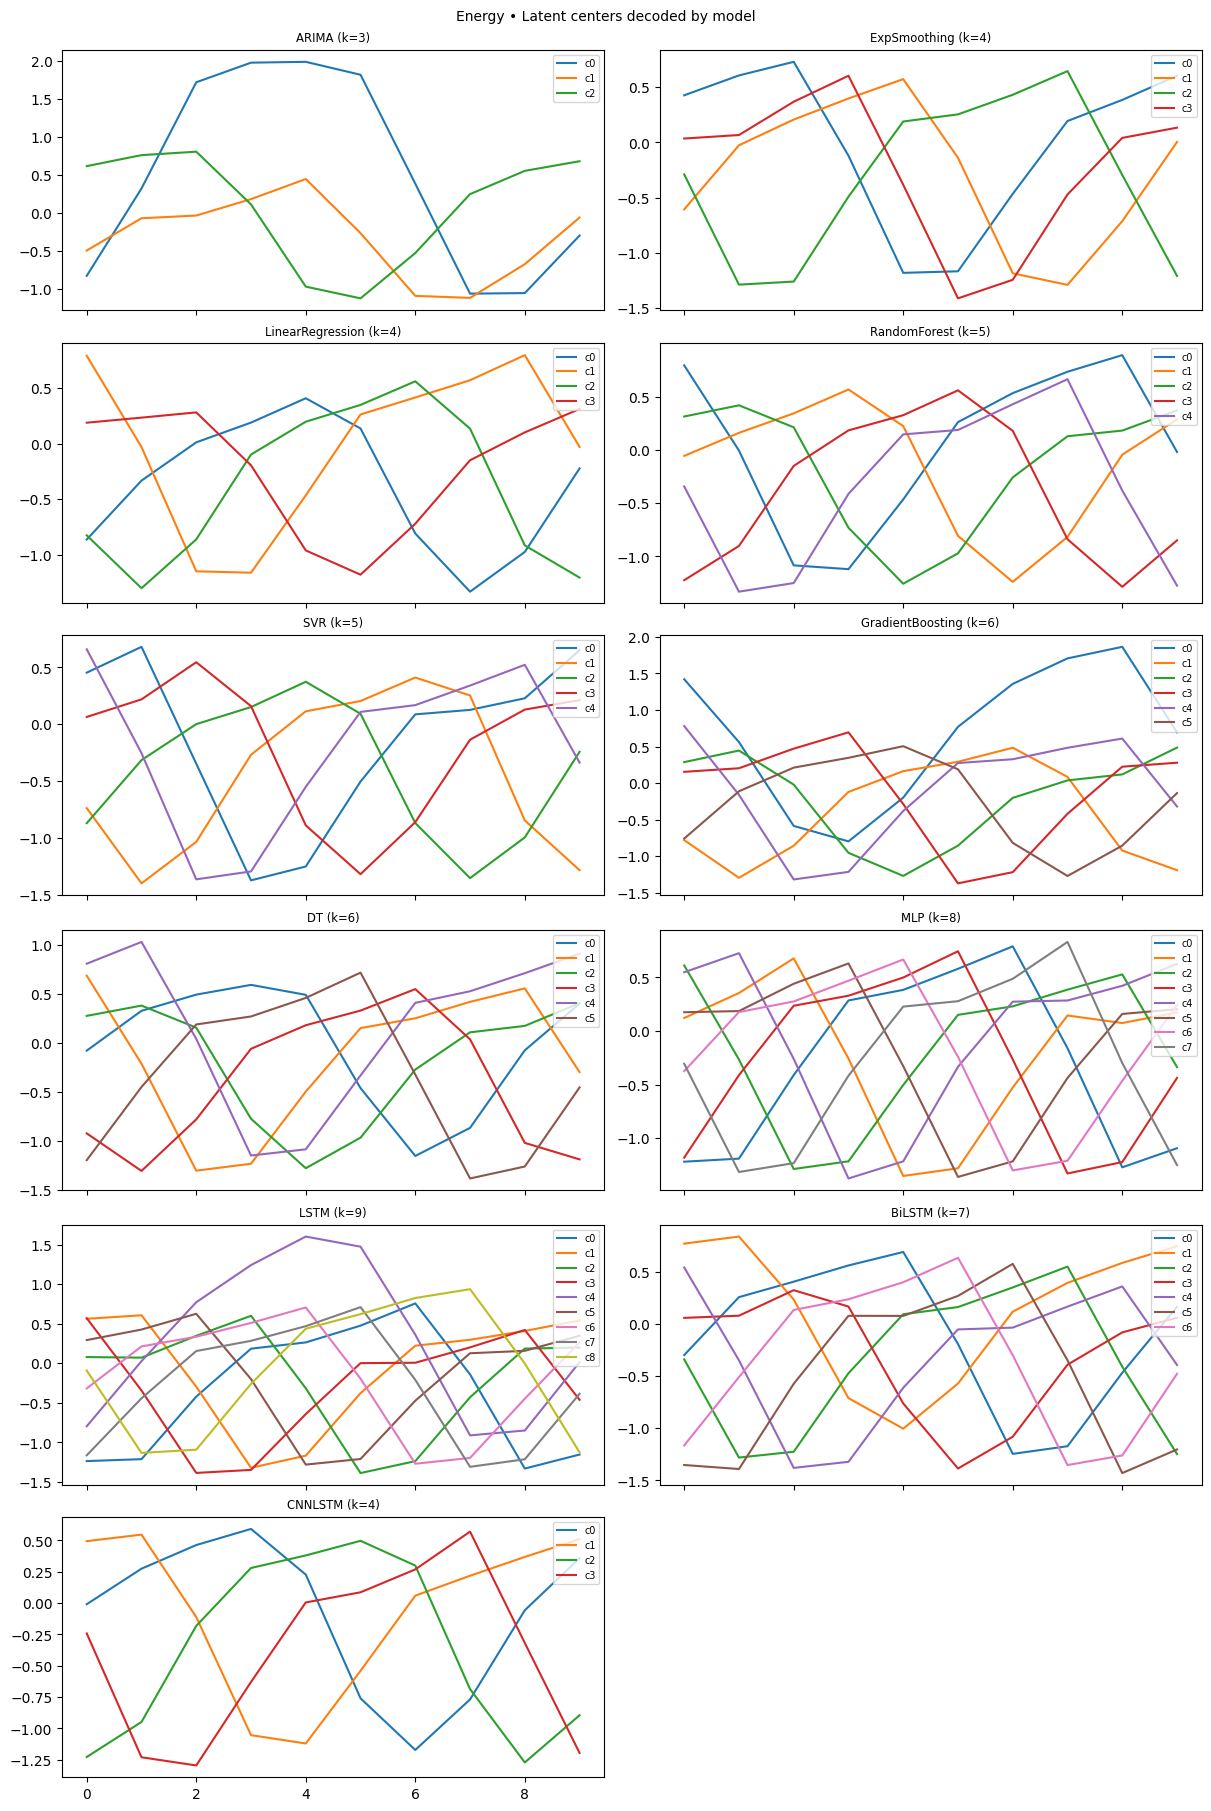


=== Compute K-means centers for RiverFlow (window_size=10) ===


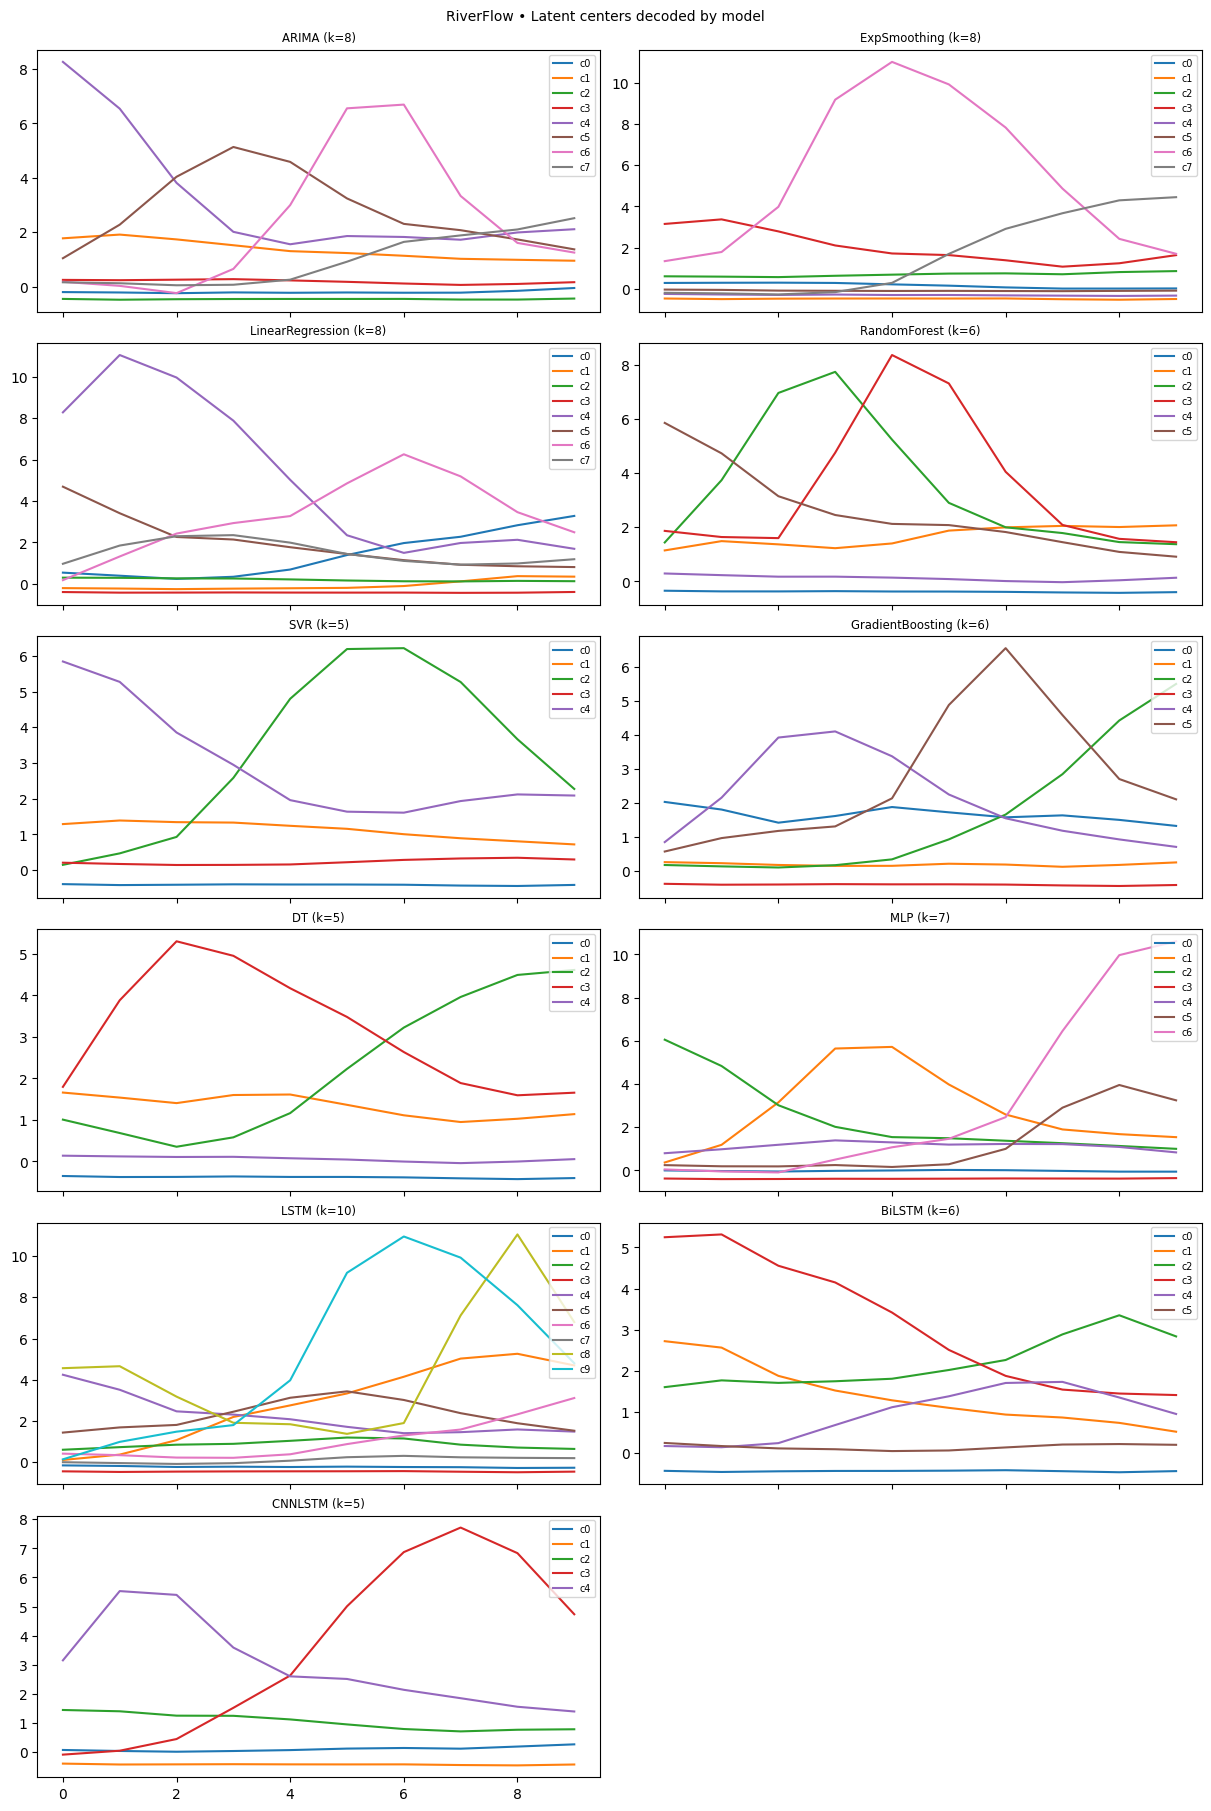


=== Compute K-means centers for Temperatures (window_size=10) ===


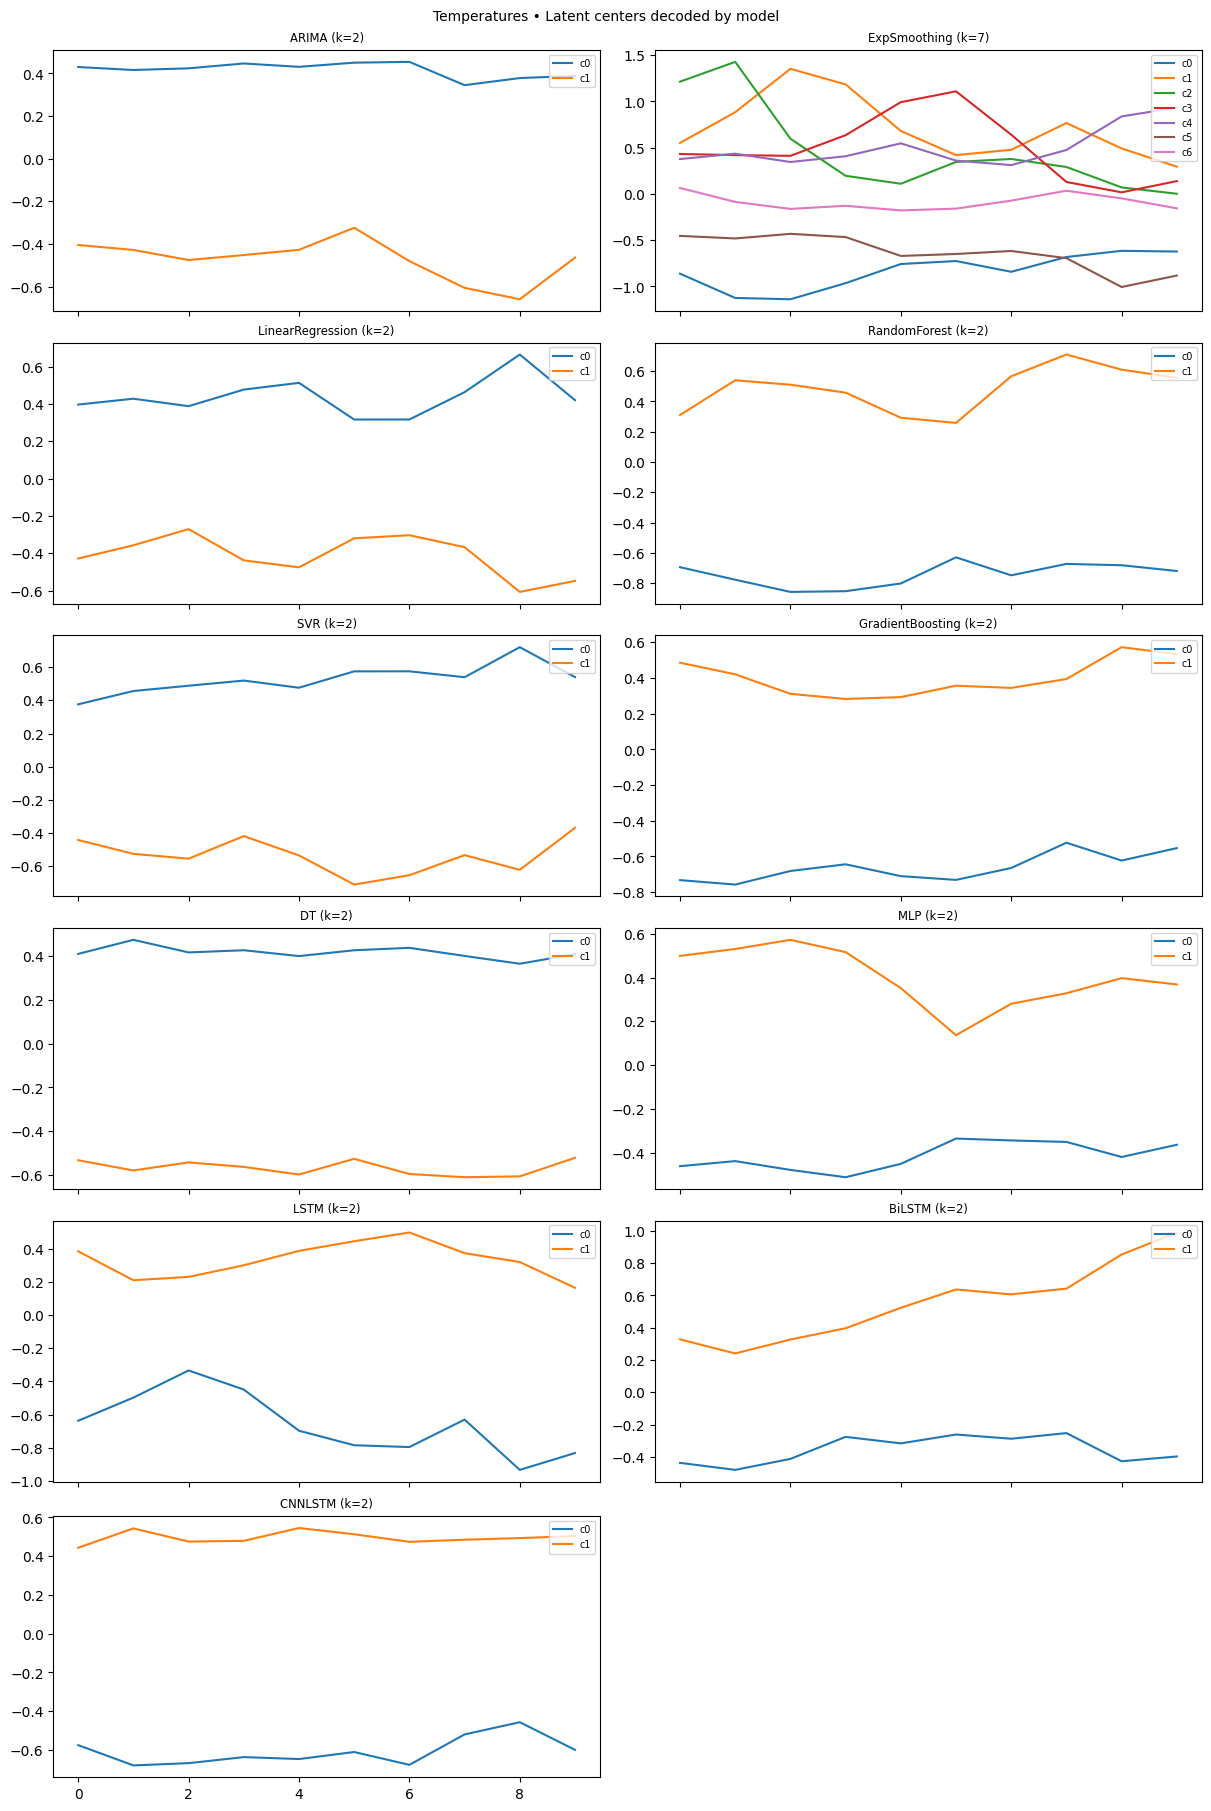


=== Compute K-means centers for Births (window_size=10) ===


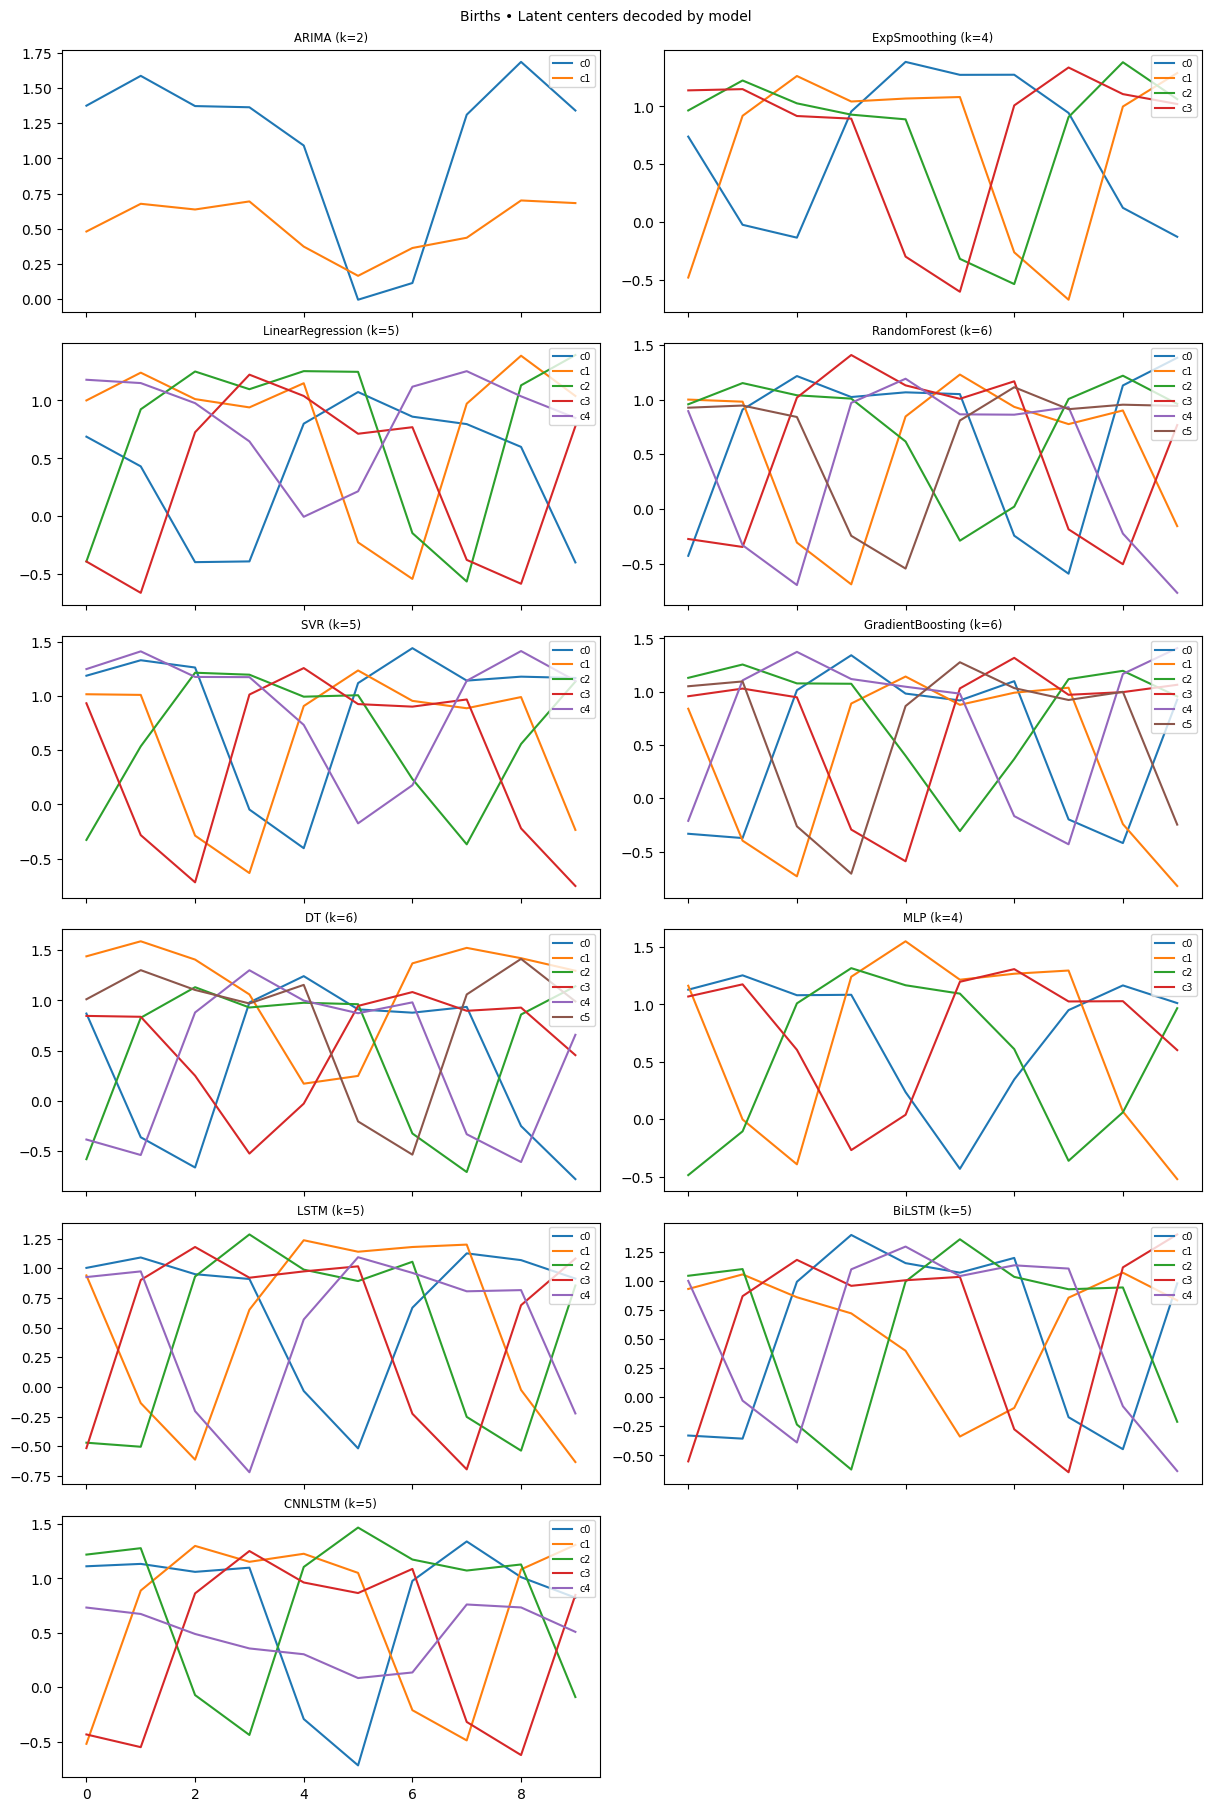

In [7]:
print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Compute K-means centers for {ds_name} (window_size={window_size}) ===")

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear previous latent centers
    for model in forecasters.values():
        model.centers.clear()

    # Determine device for decoding
    decoder_device = next(ae.decoder.parameters()).device

    for name, model in forecasters.items():
        # compute latent-only k-means centers
        N      = len(model.rocs["latent"])
        k_max  = np.sqrt(N/2)
        best_k = model.compute_kmeans_centers(k_max=k_max)

    # Plot
    names = [n for n in forecasters if len(forecasters[n].centers) > 0]
    n_models = len(names)
    if n_models == 0:
        print("  No models have centers to plot.")
        continue

    n_cols = 2
    n_rows = math.ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(12, 3 * n_rows),
                             sharex=True, constrained_layout=True)
    axes = axes.flatten()

    for ax, name in zip(axes, names):
        model = forecasters[name]
        for idx, c in enumerate(model.centers):
            # ensure tensor on correct device
            c_tensor = c if isinstance(c, torch.Tensor) else torch.tensor(
                c, dtype=torch.float32
            )
            c_batch = c_tensor.unsqueeze(0).to(decoder_device)  # shape (1, C, L)
            decoded = ae.decoder(c_batch)                       # -> (1, 1, window_size)
            ts_data = decoded.detach().cpu().numpy().flatten()
            ax.plot(ts_data, label=f"c{idx}")
        ax.set_title(f"{name} (k={len(model.centers)})", fontsize="small")
        ax.legend(loc="upper right", fontsize="x-small")

    # turn off any unused subplots
    for ax in axes[n_models:]:
        ax.axis("off")

    plt.suptitle(f"{ds_name} • Latent centers decoded by model", fontsize="medium")
    plt.show()

## RQ1: Latent vs. Raw Space for Model Selection Across Distance Metrics

The goal is to compare the effectiveness of model selection based on similarity in latent space via autoencoder embeddings versus raw time-domain. This comparison is conducted across multiple distance measures, including Euclidean, Cosine, and Manhattan, applied in both raw and latent spaces.

### Test 1.1: Forecasting MSE Comparison

We compare one-step-ahead forecasting error (MSE) when selecting forecaster in raw vs. latent space using three distance metrics. For each, lower MSE from latent-space selection indicates that the latent embedding preserves meaningful similarity under the corresponding metric. 

In [8]:
# Lists to collect detailed disagreements, high-level summaries, and neighbor sets
disagreements = []
summary_list = []
neighbor_data = []

# Ensure a clean results/ directory
RESULTS_DIR = "results"
if os.path.exists(RESULTS_DIR):
    shutil.rmtree(RESULTS_DIR)
os.makedirs("results", exist_ok=True)

print(f"Bottleneck size: {latent_dim}")

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")

    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load forecasters
    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    n_windows = len(X_test)

    for metric in metrics_list:
        # prepare neighbor-set collectors
        raw_neighbor_sets = []
        lat_neighbor_sets = []

        # ---- RAW inference ----
        t0 = time.perf_counter()
        raw_preds, raw_models = [], []
        for w in X_test:
            q = w
            best_name, best_dist = None, float("inf")
            window_dists = []
            for name, model in forecasters.items():
                for entry in model.rocs["raw"]:
                    d = compute_distance(q, entry, metric=metric)
                    window_dists.append((d, name))
                    if d < best_dist:
                        best_dist, best_name = d, name
            raw_models.append(best_name)
            window_dists.sort(key=lambda x: x[0])
            raw_neighbor_sets.append([name for _, name in window_dists[:5]])
            raw_preds.append(forecasters[best_name].predict(w))
        time_raw = time.perf_counter() - t0
        mse_raw  = mean_squared_error(y_test, raw_preds)

        # ---- LATENT inference ----
        t1 = time.perf_counter()
        lat_preds, lat_models = [], []
        for w in X_test:
            with torch.no_grad():
                q = ae.encode(w).cpu()
            best_name, best_dist = None, float("inf")
            window_dists = []
            for name, model in forecasters.items():
                for entry in model.rocs["latent"]:
                    d = compute_distance(q, entry, metric=metric)
                    window_dists.append((d, name))
                    if d < best_dist:
                        best_dist, best_name = d, name
            lat_models.append(best_name)
            window_dists.sort(key=lambda x: x[0])
            lat_neighbor_sets.append([name for _, name in window_dists[:5]])
            lat_preds.append(forecasters[best_name].predict(w))
        time_lat = time.perf_counter() - t1
        mse_lat  = mean_squared_error(y_test, lat_preds)

        # ---- Record neighbor‐sets for later Jaccard analysis ----
        for idx in range(n_windows):
            neighbor_data.append({
                "dataset":       ds_name,
                "metric":        metric,
                "win_idx":       idx,
                "raw_neighbors": raw_neighbor_sets[idx],
                "lat_neighbors": lat_neighbor_sets[idx],
            })

        # ---- Record disagreements ----
        n_dis = 0
        for idx, (rm, lm, yt, pr, pl) in enumerate(zip(raw_models, lat_models, y_test, raw_preds, lat_preds)):
            if rm != lm:
                n_dis += 1
                disagreements.append({
                    "dataset":      ds_name,
                    "metric":       metric,
                    "win_idx":      idx,
                    "raw_model":    rm,
                    "lat_model":    lm,
                    "y_true":       yt,
                    "y_pred_raw":   pr,
                    "y_pred_lat":   pl,
                })
        rate = n_dis / n_windows

        # ---- Append summary ----
        summary_list.append({
            "dataset":          ds_name,
            "metric":           metric,
            "test_mse_raw":     mse_raw,
            "test_mse_lat":     mse_lat,
            "time_raw":         time_raw,
            "time_lat":         time_lat,
            "n_disagreements":  n_dis,
            "disagreement_rate":rate,
        })

        # ---- Print results ----
        print(
            f"[{metric:^9}] "
            f"raw MSE={mse_raw:.4f}@{time_raw:.2f}s | "
            f"lat MSE={mse_lat:.4f}@{time_lat:.2f}s | "
            f"dis={n_dis}/{n_windows} ({rate:.2%})  | "
            f"%‐improvement: {1 - mse_lat/mse_raw:.2%}"
        )

# Build DataFrames and save
df_dis = pd.DataFrame(disagreements)
df_sum = pd.DataFrame(summary_list)
df_nei = pd.DataFrame(neighbor_data)

df_dis.to_csv("results/disagreements.csv", index=False)
df_sum.to_csv("results/validation.csv",    index=False)
df_nei.to_csv("results/neighbor_sets.csv", index=False)


Bottleneck size: 8

=== Dataset: Energy ===
[euclidean] raw MSE=0.0497@26.17s | lat MSE=0.0494@62.51s | dis=1155/2913 (39.65%)  | %‐improvement: 0.71%
[manhattan] raw MSE=0.0498@30.97s | lat MSE=0.0488@67.98s | dis=1336/2913 (45.86%)  | %‐improvement: 2.08%
[ cosine  ] raw MSE=0.0446@47.65s | lat MSE=0.0472@151.16s | dis=1397/2913 (47.96%)  | %‐improvement: -5.76%

=== Dataset: RiverFlow ===
[euclidean] raw MSE=0.1019@105.63s | lat MSE=0.0993@257.13s | dis=2496/5926 (42.12%)  | %‐improvement: 2.62%
[manhattan] raw MSE=0.1025@132.33s | lat MSE=0.1011@275.05s | dis=2539/5926 (42.85%)  | %‐improvement: 1.39%
[ cosine  ] raw MSE=0.1083@196.79s | lat MSE=0.1047@727.22s | dis=4418/5926 (74.55%)  | %‐improvement: 3.35%

=== Dataset: Temperatures ===
[euclidean] raw MSE=0.3325@28.74s | lat MSE=0.3452@75.50s | dis=398/903 (44.08%)  | %‐improvement: -3.82%
[manhattan] raw MSE=0.3372@29.88s | lat MSE=0.3448@85.12s | dis=435/903 (48.17%)  | %‐improvement: -2.26%
[ cosine  ] raw MSE=0.3287@29.38s |

### Test 1.2: Win Rate Analysis

For each metric, we compute the win-rate as the fraction of windows where the latent-space model outperforms the raw model . A win-rate above 50% indicates more frequent wins for the latent model. This analysis complements MSE results to explore whether performance gains arise from consistent small wins or a few large ones.

In [9]:
print(f"Bottleneck size: {latent_dim}")

df_dis['raw_error'] = (df_dis['y_pred_raw'] - df_dis['y_true'])**2
df_dis['lat_error'] = (df_dis['y_pred_lat'] - df_dis['y_true'])**2
df_dis['winner'] = np.where(df_dis['lat_error'] < df_dis['raw_error'],
                            'latent', 'raw')

# Count wins among disagreements
win_counts = (
    df_dis
    .groupby(['dataset','metric','winner'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={'raw':'raw_wins','latent':'latent_wins'})
)

# Compute win‐rates (conditional on disagreement)
win_rates = win_counts.div(win_counts.sum(axis=1), axis=0) \
                      .rename(columns={'raw_wins':'raw_win_rate',
                                       'latent_wins':'latent_win_rate'})

# Merge rates into the summary table
df_full = (
    df_sum
    .merge(win_rates.reset_index(), on=['dataset','metric'], how='left')
    .fillna(0)
    .assign(
        same_decision_rate = 1 - df_sum['disagreement_rate']
    )
)

# Display results
display(
    df_full[[
        'dataset','metric',
        'raw_win_rate','latent_win_rate','same_decision_rate'
    ]]
)

# Save for later
win_rates.to_csv("results/win_rates.csv", index=False)

Bottleneck size: 8


,dataset,metric,raw_win_rate,latent_win_rate,same_decision_rate
0,Energy,euclidean,0.497835,0.502165,0.603502
1,Energy,manhattan,0.488772,0.511228,0.541366
2,Energy,cosine,0.511095,0.488905,0.520426
3,RiverFlow,euclidean,0.509215,0.490785,0.578805
4,RiverFlow,manhattan,0.514770,0.485230,0.571549
5,RiverFlow,cosine,0.511317,0.488683,0.254472
6,Temperatures,euclidean,0.535176,0.464824,0.559247
7,Temperatures,manhattan,0.540230,0.459770,0.518272
8,Temperatures,cosine,0.469340,0.530660,0.530454
9,Births,euclidean,0.507143,0.492857,0.614750


To complement the unweighted win-rate analysis, we compute weighted win rates that account for the magnitude of prediction errors. For each window, we calculate the mean squared error (MSE) for both the latent and raw models, and assign a weight equal to the larger of the two errors. The “winner” for each window is determined based on which model yields the lower MSE. We then sum these weights separately for the latent and raw models across all windows and compute each model’s share of the total weight, yielding a weighted win rate. 

This approach emphasizes not just how often a model wins, but how significant its wins are—highlighting whether improvements arise from consistent small gains or occasional large differences.

In [10]:
print(f"Bottleneck size: {latent_dim}")

# --- 1. Compute per-window errors and weights ---
df_dis['mse_raw']    = (df_dis['y_pred_raw']   - df_dis['y_true'])**2
df_dis['mse_latent'] = (df_dis['y_pred_lat']   - df_dis['y_true'])**2
df_dis['weight']     = df_dis[['mse_raw','mse_latent']].max(axis=1)

# --- 2. Determine per-window “winner” ---
df_dis['winner'] = np.where(
    df_dis['mse_latent'] < df_dis['mse_raw'],
    'latent', 'raw'
)

# --- 3. Sum weights by dataset, metric, and winner ---
weight_sums = (
    df_dis
    .groupby(['dataset','metric','winner'])['weight']
    .sum()
    .unstack(fill_value=0)
    .rename(columns={'raw':'raw_weight','latent':'latent_weight'})
)

# --- 4. Compute weighted win‐rates ---
weighted_win_rates = (
    weight_sums
    .div(weight_sums.sum(axis=1), axis=0)
    .rename(columns={
        'raw_weight':    'raw_weighted_win_rate',
        'latent_weight': 'latent_weighted_win_rate'
    })
)

# --- 5. Merge into your summary and compute same_decision_rate ---
df_full = (
    df_sum
    .merge(weighted_win_rates.reset_index(), on=['dataset','metric'], how='left')
    .assign(same_decision_rate = 1 - df_sum['disagreement_rate'])
)

# --- 6. Display & save ---
display(df_full[[
    'dataset','metric',
    'raw_weighted_win_rate',
    'latent_weighted_win_rate',
    'same_decision_rate'
]])

weighted_win_rates.to_csv("results/weighted_win_rates.csv")

Bottleneck size: 8


,dataset,metric,raw_weighted_win_rate,latent_weighted_win_rate,same_decision_rate
0,Energy,euclidean,0.514136,0.485864,0.603502
1,Energy,manhattan,0.483905,0.516095,0.541366
2,Energy,cosine,0.533726,0.466274,0.520426
3,RiverFlow,euclidean,0.478588,0.521412,0.578805
4,RiverFlow,manhattan,0.647287,0.352713,0.571549
5,RiverFlow,cosine,0.471001,0.528999,0.254472
6,Temperatures,euclidean,0.565159,0.434841,0.559247
7,Temperatures,manhattan,0.576063,0.423937,0.518272
8,Temperatures,cosine,0.488418,0.511582,0.530454
9,Births,euclidean,0.455814,0.544186,0.614750


### Test 1.3: Neighbor-Set Overlap

For each window $w$, let $N_{\mathrm{raw}}(w)$ and $N_{\mathrm{lat}}(w)$ be its top-$k$ forecasters under raw vs. latent distances. Define the Jaccard index

$$
J(w) \;=\; \frac{\lvert N_{\mathrm{raw}}(w)\,\cap\,N_{\mathrm{lat}}(w)\rvert}{\lvert N_{\mathrm{raw}}(w)\,\cup\,N_{\mathrm{lat}}(w)\rvert},
$$

and the mean overlap

$$
\bar J \;=\; \frac{1}{W}\sum_{w=1}^W J(w),
$$

where $W$ is the number of test windows.

**Interpretation**  
- $\bar J \ge 0.8$: forecaster choice largely preserved  
- $0.5 \le \bar J < 0.8$: moderate reshaping  
- $\bar J < 0.5$: fundamentally different forecaster choices  


In [11]:
# 1. Load the neighbor‐sets CSV
df_nei = pd.read_csv("results/neighbor_sets.csv")

# 2. Parse the stored strings into Python lists
def parse_list(s):
    items = s.strip("[]").split(",")
    return [item.strip().strip("'\"") for item in items if item.strip()]

df_nei["raw_neighbors"] = df_nei["raw_neighbors"].apply(parse_list)
df_nei["lat_neighbors"] = df_nei["lat_neighbors"].apply(parse_list)

# 3. Compute Jaccard index for each window
def jaccard(a, b):
    A, B = set(a), set(b)
    return len(A & B) / len(A | B) if (A | B) else 0.0

df_nei["jaccard"] = df_nei.apply(
    lambda row: jaccard(row["raw_neighbors"], row["lat_neighbors"]),
    axis=1
)

# 4. Aggregate average overlap per dataset and metric
jaccard_summary = (
    df_nei
    .groupby(["dataset", "metric"])["jaccard"]
    .mean()
    .reset_index()
    .rename(columns={"jaccard": "avg_jaccard_overlap"})
)

# 5. Reorder metrics
metric_order = ["euclidean", "manhattan", "cosine"]
jaccard_summary["metric"] = pd.Categorical(
    jaccard_summary["metric"], categories=metric_order, ordered=True
)
jaccard_summary = jaccard_summary.sort_values(["dataset", "metric"])

# 6. Display and interpret in specified metric order
print("Average Jaccard Overlap by Dataset & Metric (ordered):")
print(jaccard_summary.to_string(index=False))

Average Jaccard Overlap by Dataset & Metric (ordered):
     dataset    metric  avg_jaccard_overlap
      Births euclidean             0.685685
      Births manhattan             0.664991
      Births    cosine             0.657026
      Energy euclidean             0.683194
      Energy manhattan             0.638887
      Energy    cosine             0.646201
   RiverFlow euclidean             0.655125
   RiverFlow manhattan             0.649691
   RiverFlow    cosine             0.390713
Temperatures euclidean             0.635208
Temperatures manhattan             0.618320
Temperatures    cosine             0.601259


## RQ2: Cluster-Based Latent Selection
Model selection is performed using nearest latent cluster centers instead of full RoCs. For each test window, the closest cluster center (per metric) is used to select the forecasting model. Inference time and test MSE are recorded.


### Test 2.1: Forecasting MSE Comparison

Again here we compare one-step-ahead forecasting error (MSE) when selecting forecaster with the full RoC versus the cluster centers computer earlier using the same three distance metrics: Euclidean, Manhattan, and Cosine.

In [12]:
# Load previously computed summary for raw vs. latent
df_prev = pd.read_csv("results/validation.csv")

summary_list = []

print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")

    # rebuild splits
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load forecasters and AE
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    n_windows   = len(X_test)

    for metric in metrics_list:
        # ---- LATENT inference (cluster-center lookup) ----
        t0 = time.perf_counter()
        lat_preds = []
        for w in X_test:
            # encode window
            with torch.no_grad():
                q = ae.encode(w).cpu()

            best_name, best_dist = None, float("inf")
            for name, model in forecasters.items():
                for center in model.centers:
                    d = compute_distance(q, center, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name

            lat_preds.append(forecasters[best_name].predict(w))

        time_cluster = time.perf_counter() - t0
        mse_cluster  = mean_squared_error(y_test, lat_preds)

        # fetch standard latent‐based results
        prev_row      = df_prev[(df_prev['dataset']==ds_name)&(df_prev['metric']==metric)].iloc[0]
        mse_standard_lat  = prev_row['test_mse_lat']
        mse_raw_lat  = prev_row['test_mse_raw']
        time_standard_lat = prev_row['time_lat']

        # compute delta and print with arrow‐style indicator
        delta = mse_cluster - mse_standard_lat
        sign  = "+" if delta > 0 else "–"
        print(
            f"[{metric:^9}] "
            f"cluster MSE={mse_cluster:.4f}@{time_cluster:.2f}s | "
            f"%‐improvement(vs. full lat RoC): {1 - mse_cluster/mse_standard_lat:.2%} | "
            f"%‐improvement(vs. full raw RoC): {1 - mse_cluster/mse_raw_lat:.2%}"
        )

        summary_list.append({
            "dataset":       ds_name,
            "metric":        metric,
            "cluster_mse":   mse_cluster,
            "time_cluster":  time_cluster,
        })

# tabulate and save
df_sum = pd.DataFrame(summary_list)
df_sum.to_csv("results/cluster.csv", index=False)

Bottleneck size: 8

=== Dataset: Energy ===
[euclidean] cluster MSE=0.0599@219.71s | %‐improvement(vs. full lat RoC): -21.19% | %‐improvement(vs. full raw RoC): -20.34%
[manhattan] cluster MSE=0.0636@366.42s | %‐improvement(vs. full lat RoC): -30.34% | %‐improvement(vs. full raw RoC): -27.63%
[ cosine  ] cluster MSE=0.0588@378.09s | %‐improvement(vs. full lat RoC): -24.60% | %‐improvement(vs. full raw RoC): -31.78%

=== Dataset: RiverFlow ===
[euclidean] cluster MSE=0.1005@376.65s | %‐improvement(vs. full lat RoC): -1.31% | %‐improvement(vs. full raw RoC): 1.35%
[manhattan] cluster MSE=0.0977@164.82s | %‐improvement(vs. full lat RoC): 3.34% | %‐improvement(vs. full raw RoC): 4.68%
[ cosine  ] cluster MSE=0.0989@513.92s | %‐improvement(vs. full lat RoC): 5.50% | %‐improvement(vs. full raw RoC): 8.66%

=== Dataset: Temperatures ===
[euclidean] cluster MSE=0.3324@2.91s | %‐improvement(vs. full lat RoC): 3.70% | %‐improvement(vs. full raw RoC): 0.02%
[manhattan] cluster MSE=0.3441@2.77s | 

### Test 2.2: Visualization

Four random test windows are encoded using the autoencoder, then matched to the closest RoC entry across all models based on a distance metric. The nearest cluster center within the selected model is identified and decoded back to input space. The original window and its decoded prototype are plotted to illustrate how well the chosen latent representation captures the input structure.

Processing dataset: Energy


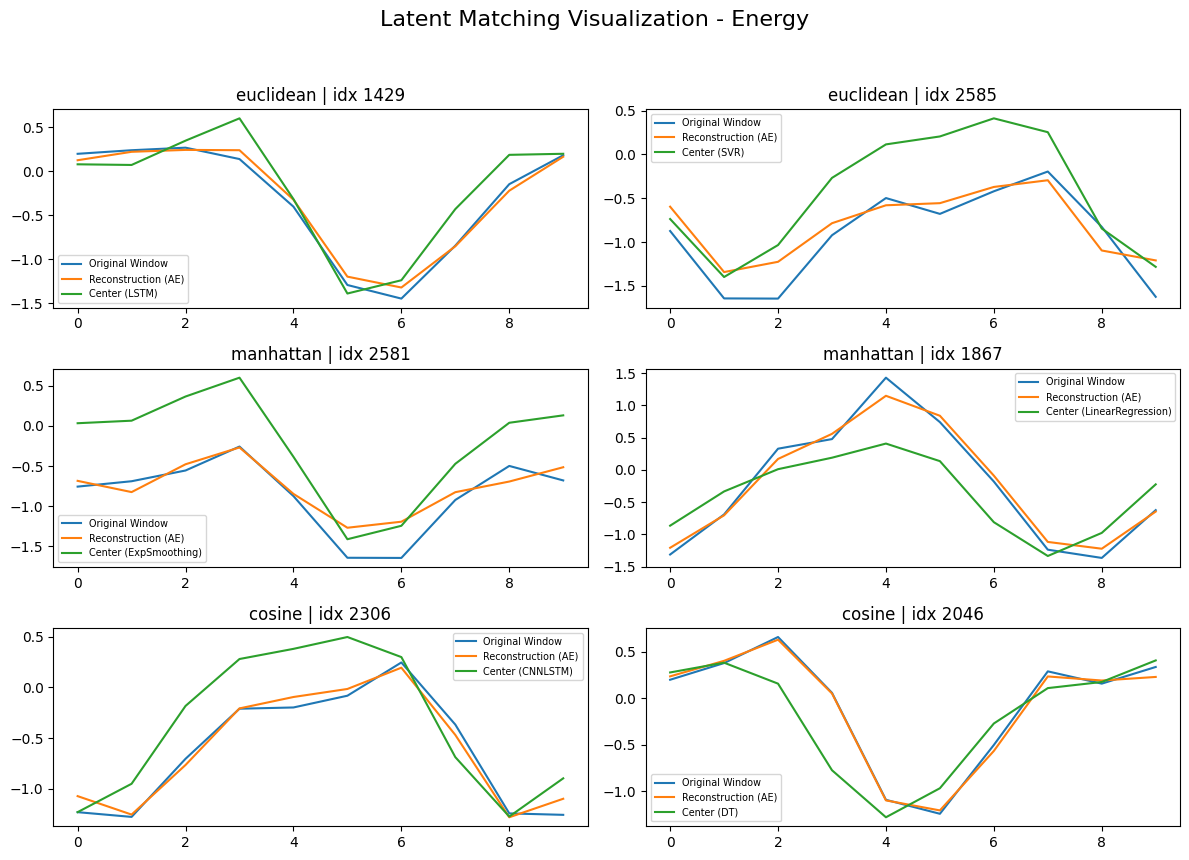

Processing dataset: RiverFlow


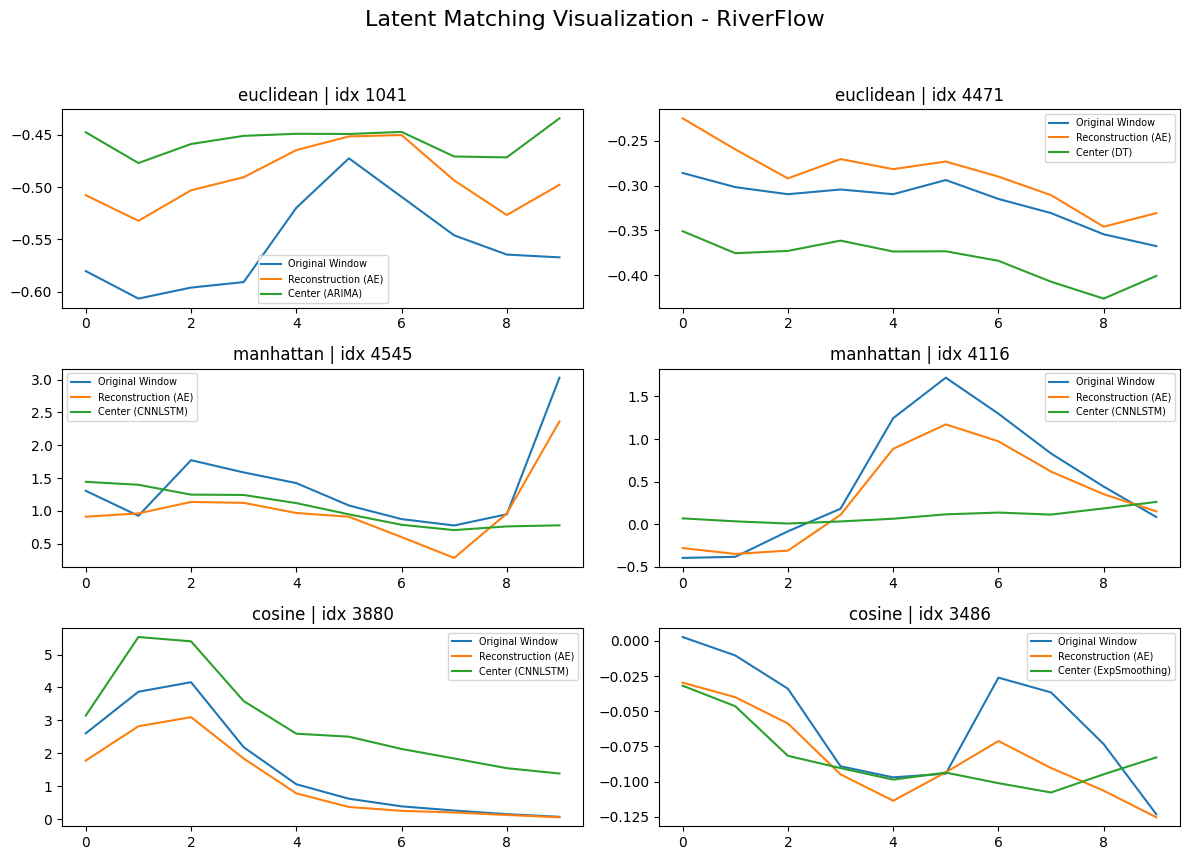

Processing dataset: Temperatures


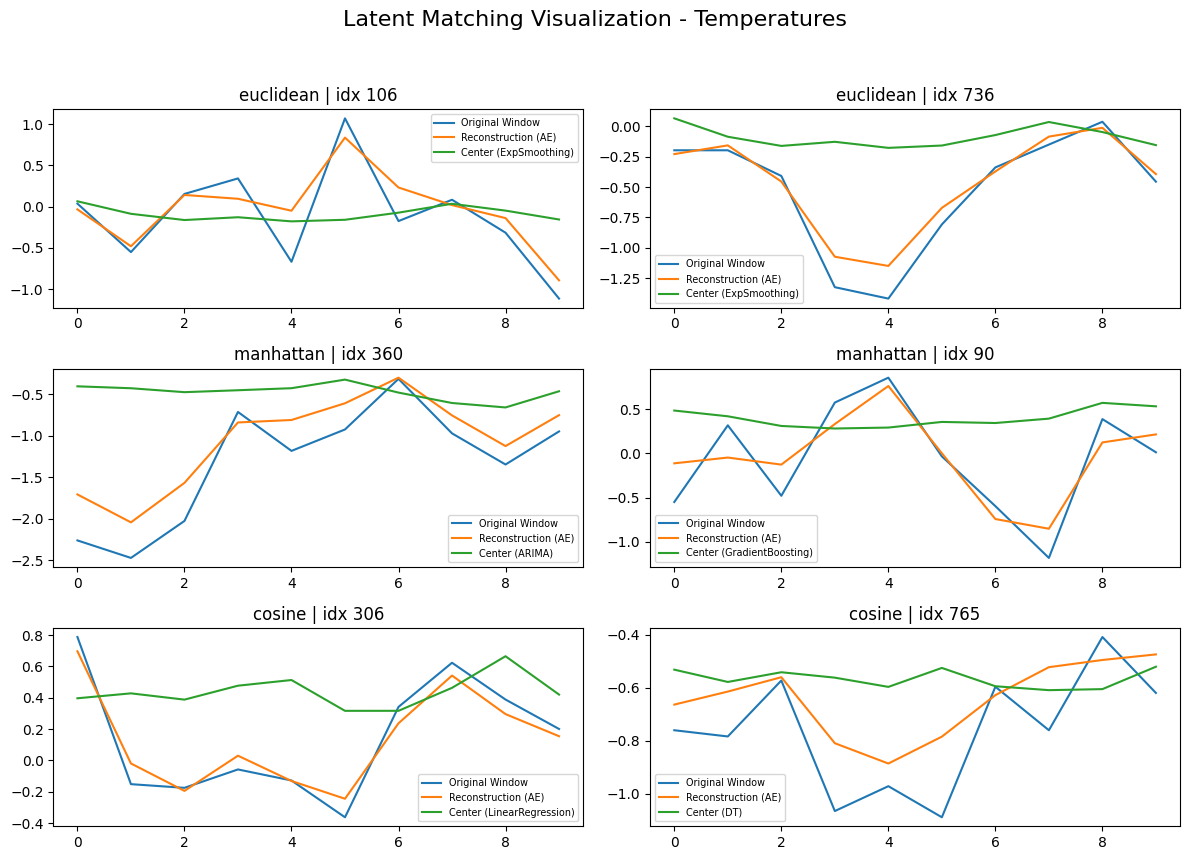

Processing dataset: Births


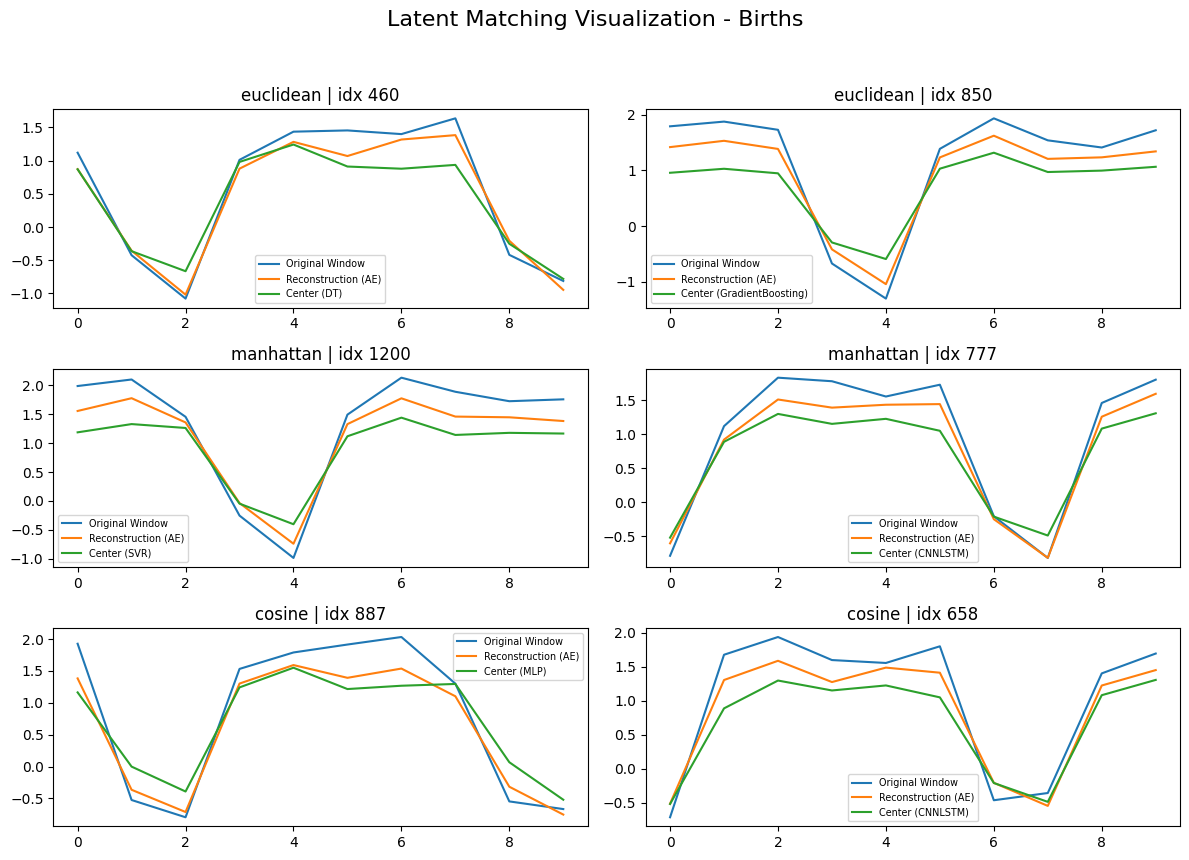

In [13]:
for ds_name, DS, length, window_size in ts_configs:
    print(f"Processing dataset: {ds_name}")

    # Load dataset and create test windows
    ts = DS(length=length)
    _, _, _, _, X_test, _ = windowing(ts.data, window_size)

    # Load AE and forecasters
    ae = loaded[ds_name]['ae']
    forecasters = loaded[ds_name]['forecasters']
    decoder = ae.decoder
    decoder_device = next(decoder.parameters()).device

    # Prepare 3x2 subplot grid: 3 metrics × 2 windows per metric
    fig, axes = plt.subplots(len(metrics_list), 2, figsize=(12, 9))
    axes = axes.reshape(-1, 2)  # Ensure consistent indexing

    for i, metric in enumerate(metrics_list):
        idxs = random.sample(range(len(X_test)), 2)

        for j, idx in enumerate(idxs):
            ax = axes[i, j]
            w = X_test[idx]  # NumPy array

            # 1. Encode the window
            z = ae.encode(w)  # shape: (C, L)

            # 2. Reconstruct using decoder
            z_tensor = torch.tensor(z, dtype=torch.float32).unsqueeze(0).to(decoder_device)
            with torch.no_grad():
                w_recon = ae.decoder(z_tensor).cpu().numpy().flatten()

            # 3. Find closest model based on latent RoC
            best_model, best_dist = None, float('inf')
            for name, model in forecasters.items():
                for entry in model.rocs['latent']:
                    entry_tensor = entry if isinstance(entry, torch.Tensor) else torch.tensor(entry, dtype=torch.float32)
                    entry_tensor = entry_tensor.to(z_tensor.device).squeeze(0)  # Ensure shape match
                    d = compute_distance(z_tensor.squeeze(0), entry_tensor, metric=metric)
                    if d < best_dist:
                        best_dist, best_model = d, name

            # 4. Find closest prototype in selected model
            model = forecasters[best_model]
            best_center, best_c_dist = None, float('inf')
            for c in model.centers:
                c_tensor = c if isinstance(c, torch.Tensor) else torch.tensor(c, dtype=torch.float32)
                c_tensor = c_tensor.to(z_tensor.device)
                d = compute_distance(z_tensor.squeeze(0), c_tensor, metric=metric)
                if d < best_c_dist:
                    best_c_dist, best_center = d, c_tensor

            # 5. Decode prototype
            c_batch = best_center.unsqueeze(0).to(decoder_device)
            with torch.no_grad():
                proto = decoder(c_batch).cpu().numpy().flatten()

            # 6. Plot all
            ax.plot(w, label='Original Window')
            ax.plot(w_recon, label='Reconstruction (AE)')
            ax.plot(proto, label=f'Center ({best_model})')
            ax.set_title(f"{metric} | idx {idx}")
            ax.legend(fontsize='x-small')

    # Final layout
    fig.suptitle(f"Latent Matching Visualization - {ds_name}", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
